In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from river import linear_model, optim
from river import metrics
import plotly.express as px
import pickle

In [2]:
df = pd.read_csv("../data/input/AAPL.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Extract date-based features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["MA_5"] = df["Adj Close"].rolling(window=5).mean().shift(1)  # 5-day moving average
df["MA_10"] = df["Adj Close"].rolling(window=10).mean().shift(1)  # 10-day moving average
df["Volatility"] = df["Adj Close"].rolling(window=5).std().shift(1)
df["Momentum"] = df["Adj Close"].diff(5).shift(1)

# Create a lag feature (previous day's adjusted close)
df["Prev_Close"] = df["Adj Close"].shift(1)
df.dropna(inplace=True)  # Remove first row with NaN

In [3]:
# Convert to river format
dataset = [
    (
        {
            "Year": row["Year"],
            "Month": row["Month"],
            "DayOfWeek": row["DayOfWeek"],
            "Prev_Close": row["Prev_Close"],
            "MA_5": row["MA_5"],
            "MA_10": row["MA_10"],
            "Volatility": row["Volatility"],
            "Momentum": row["Momentum"],
        },
        row["Adj Close"],
        row["Date"]  # Store date separately
    )
    for _, row in df.iterrows()
]

In [4]:
model = linear_model.LinearRegression(optimizer=optim.Adam(lr=0.009))
model

LinearRegression (
  optimizer=Adam (
    lr=Constant (
      learning_rate=0.009
    )
    beta_1=0.9
    beta_2=0.999
    eps=1e-08
  )
  loss=Squared ()
  l2=0.
  l1=0.
  intercept_init=0.
  intercept_lr=Constant (
    learning_rate=0.01
  )
  clip_gradient=1e+12
  initializer=Zeros ()
)

In [5]:
# Train incrementally
for x, y, _ in dataset:
    model.learn_one(x, y)
    print("Prediction:", model.predict_one(x))

Prediction: 25.83401570221781
Prediction: 50.967214488370594
Prediction: 75.39239682734843
Prediction: 98.80394511608392
Prediction: 120.78196093864632
Prediction: 141.2805228883952
Prediction: 159.99636116701305
Prediction: 176.37660082129804
Prediction: 190.28779409323903
Prediction: 200.62982793214326
Prediction: 208.30640461757272
Prediction: 213.03308381131777
Prediction: 215.2621589018997
Prediction: 215.44015000553784
Prediction: 213.30478989062536
Prediction: 209.7977256236362
Prediction: 204.69687187780212
Prediction: 198.49636321704565
Prediction: 192.41834682976923
Prediction: 185.89594203445404
Prediction: 179.52202475419418
Prediction: 173.4318155990754
Prediction: 167.93392185384795
Prediction: 162.94456913113882
Prediction: 159.2908945559691
Prediction: 156.26154772615658
Prediction: 154.11942599141557
Prediction: 153.38033088725612
Prediction: 153.58526559462604
Prediction: 154.2863858625066
Prediction: 155.8802162565094
Prediction: 158.06161243795216
Prediction: 160.63

In [6]:
# Evaluate model
def evaluate_model(model, dataset): 
    metric = metrics.MAE()  # Use MAE directly

    dates = []
    y_trues = []
    y_preds = []

    for x, y, date in dataset:  # Unpack date
        y_pred = model.predict_one(x)  # Predict
        model.learn_one(x, y)  # Train

        metric.update(y, y_pred)  # Update metric

        # Store data for visualization
        dates.append(date)  # Use actual date
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=1, label='Actual')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(f"Model MAE: {metric.get():.2f}")
    plt.xticks(rotation=45)
    plt.show()

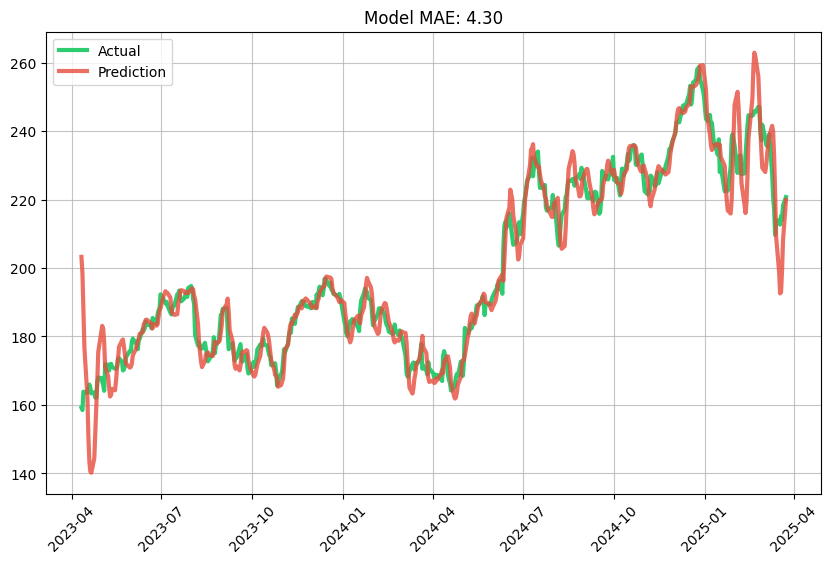

In [7]:
# Run model evaluation
evaluate_model(model, dataset)

In [8]:
# Save model
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(model, f)